# INTIS - Challenge for AI Engineer position
# ANN MODEL FOR PREDICTIONS - Agumented data

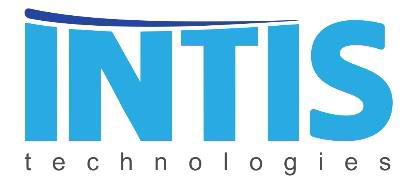

# 0. Imports

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd
import numpy as np
from sklearn import metrics, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
import matplotlib.pyplot as plt

# 1. Model

In [3]:
# Loading dataset from csv file.
vineyard_data = pd.read_csv("./data/podaci.csv", sep=",", names=["x1", "x2", "x3", "x4", "u"])
vineyard_data.head(5)

,x1,x2,x3,x4,u
0,9.353670,-5.681740,1.739091,26.117712,95.610349
1,7.136365,-8.842209,1.712237,42.389300,171.811854
2,11.457191,-8.771499,1.500788,41.984114,173.865403
3,8.772591,-4.087157,2.443511,12.612862,53.146681
4,4.958833,-8.140877,1.651389,34.904362,142.692822


## 1.1. Train and test split + preprocess

In [4]:
# Divide dataset to independent vars (x1-x4) and dependent var (u).
X = vineyard_data.iloc[:, :-1].values
y = vineyard_data.iloc[:, -1].values
# X = vineyard_data[["x2", "x4"]].values
# y = vineyard_data["u"].values

In [5]:
# Scale data to [0,1] BEFORE split to train and test set.
X = MaxAbsScaler().fit_transform(X)
y = MaxAbsScaler().fit_transform(y.reshape(-1, 1))

# Split data to training and test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=101)

## 1.2. Model creation

In [6]:
def create_model(input_shape: int, n_neurons: list):
    """Function for ANN model creation.
    
    Function will create ANN model based on input shape and the number of layer will be determined based on len(n_neurons).
    
    :param input_shape: Number of independent variables.
    :param n_neurons: List containing number of neurons for every layer of the ANN.    
    """
    model = models.Sequential()
    for i in range(len(n_neurons)):
        if i == 0:
            model.add(layers.Dense(n_neurons[i], input_shape=(input_shape,), activation='relu'))
        else:
            model.add(layers.Dense(n_neurons[i], activation='relu'))
    
    model.add(layers.Dense(1))  # Predictions.
    
    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=['mape', 'mae'])
    return model

# Create multiple models for comparison.
ann_models = []
ann_models.append(create_model(input_shape=X.shape[1], n_neurons=[64]))
ann_models.append(create_model(input_shape=X.shape[1], n_neurons=[128]))
ann_models.append(create_model(input_shape=X.shape[1], n_neurons=[128, 64]))

# Models summary.
for ann_model in ann_models:
    print(ann_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 128)               640       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_2"
______

## 1.3. Models training

In [7]:
# History of the models training.
training_history = []
for ann_model in ann_models:
    training_history.append(
        ann_model.fit(
            X_train,
            y_train,
            epochs=100,
            verbose=False,
            validation_data=(X_test, y_test)
        )    
    )

## 1.4. Evaluation plots

In [8]:
def train_val_plot(train_history: list, params: dict, title: str):
    """Plots the parameters of the ANN training history.
    
    :param train_history: List containing history of the ANN training.
    :param params: Dictionary with "param_name": "label" values.
    :param title: Plot title.
    """
    for param_name, label in params.items():
        plt.plot(train_history.history[param_name], label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.show()

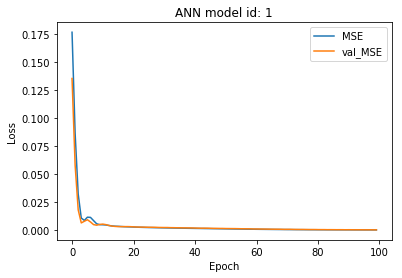

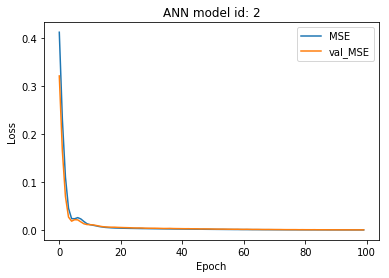

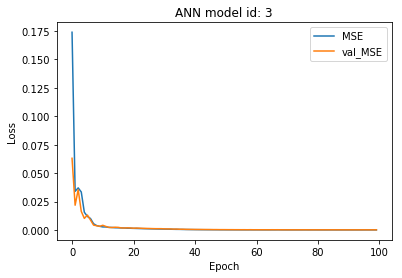

In [9]:
p = {"loss": "MSE", "val_loss": "val_MSE"}
for i in range(len(training_history)):
    train_val_plot(
        train_history=training_history[i], 
        params=p, 
        title=f"ANN model id: {i+1}"
    )

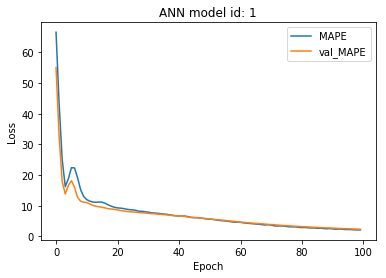

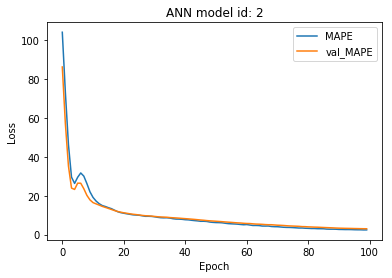

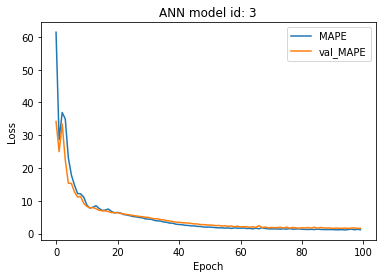

In [11]:
p = {"mape": "MAPE", "val_mape": "val_MAPE"}
for i in range(len(training_history)):
    train_val_plot(
        train_history=training_history[i], 
        params=p, 
        title=f"ANN model id: {i+1}"
    )

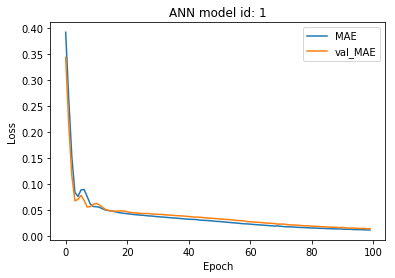

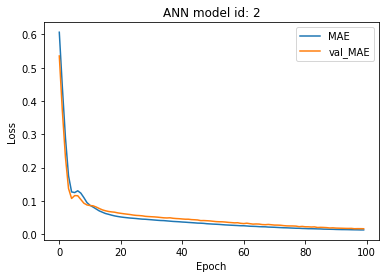

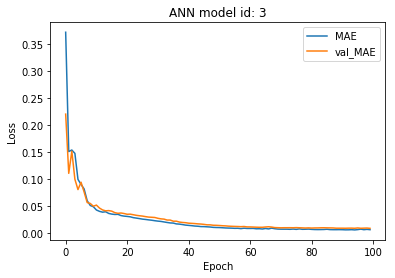

In [14]:
p = {"mae": "MAE", "val_mae": "val_MAE"}
for i in range(len(training_history)):
    train_val_plot(
        train_history=training_history[i], 
        params=p, 
        title=f"ANN model id: {i+1}"
    )

In [32]:
# This part will create a string for visualizing mape, mae, and mse in form of a MD table
table_strings = ""
for i in range(len(training_history)):
    mape = round(min(training_history[i].history["mape"]), 6)
    mae = round(min(training_history[i].history["mae"]), 6)
    mse = round(min(training_history[i].history["loss"]), 6)
    table_strings += f"| Model{i+1} | {mape} | {mae} | {mse} | \n"    

from IPython.display import Markdown as md

md(f"""
| | MAPE | MAE | MSE |
| --- | --- | --- | --- |
{table_strings}
""")


| | MAPE | MAE | MSE |
| --- | --- | --- | --- |
| Model1 | 2.108714 | 0.011758 | 0.000225 | 
| Model2 | 2.396698 | 0.013024 | 0.000272 | 
| Model3 | 1.104527 | 0.00567 | 5.4e-05 | 



In [33]:
# Saving tensorflov servable model.
tf.keras.models.save_model(
    ann_models[2],
    "models_serving/models/model_basic_data/1/",
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

INFO:tensorflow:Assets written to: models_serving/models/model_basic_data/1/assets
